In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import seaborn as sns
import numpy as np
sns.set_style('whitegrid')
sns.set_context('talk')

In [2]:
req_seq = pd.read_csv('./pop_mapping_web_3.csv', index_col=[0], header=0)
req_seq.head()

,Timestamp,Type,Offset,Size,fid
0,128166465299039421,Read,32256,8192,9
1,128166465299119535,Read,182082715136,4096,199
2,128166465299134409,Read,182082719232,4096,475
3,128166465299149505,Write,3221282304,4096,6
4,128166465299149970,Write,32256,8192,9


In [4]:
req_seq.Timestamp=(req_seq.Timestamp/100).astype('int')
req_seq.Timestamp=req_seq.Timestamp-min(req_seq.Timestamp)
start_time,end_time=min(req_seq.Timestamp),max(req_seq.Timestamp)
start_time,end_time

(0, 59437622197)

In [5]:
time_range=range(start_time,end_time+1)
print(start_time,end_time,len(time_range))

0 59437622197 59437622198


In [ ]:
manual_end=int(1e9)
ts = req_seq.fid[req_seq.fid==0][req_seq.Timestamp<manual_end]-0+1
# print(ts)
# ts=ts.reindex(time_range[:manual_end]).fillna(0)

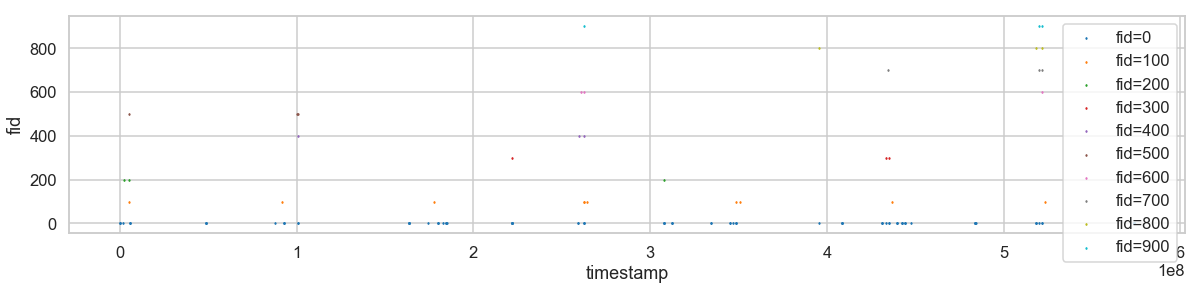

In [27]:
# plt.figure(figsize=(20, 2))
# plt.scatter(req_seq.Timestamp[req_seq.fid==0],req_seq.fid[req_seq.fid==0],s=1,marker='d')
# plt.xlabel('timestamp')
# plt.ylabel('fid')
# plt.show()

plt.figure(figsize=(20,4))
for i in range(0,1000,100):
    a = pd.DataFrame(req_seq.fid[req_seq.fid==i])
#     plt.scatter(a.index,np.zeros(len(a))+0.01*i,s=1,marker='d',label='fid='+str(i))
    plt.scatter(req_seq.Timestamp[req_seq.fid==i],req_seq.fid[req_seq.fid==i],s=1,marker='d',label='fid='+str(i))
plt.legend()
plt.xlabel('timestamp')
plt.ylabel('fid')
plt.show()

In [3]:
ts = req_seq.fid[req_seq.fid==0]
ts

8        0
12       0
43       0
643      0
4720     0
4723     0
4734     0
5126     0
5143     0
5156     0
5162     0
5323     0
5519     0
5526     0
5532     0
11197    0
11207    0
11502    0
11508    0
11518    0
11529    0
11537    0
11755    0
11880    0
11893    0
11901    0
11910    0
11922    0
11933    0
11944    0
        ..
21978    0
22607    0
25806    0
25815    0
25918    0
25931    0
25939    0
25948    0
25956    0
25963    0
25971    0
25977    0
25990    0
25996    0
26008    0
26369    0
26382    0
26396    0
26401    0
26413    0
26417    0
26422    0
27257    0
30872    0
30882    0
31000    0
31325    0
31335    0
31348    0
31359    0
Name: fid, Length: 94, dtype: int64

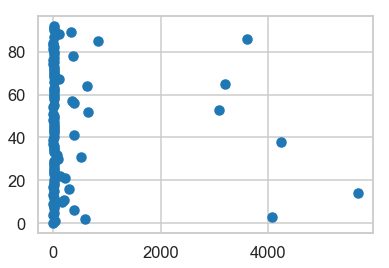

Int64Index([   4,   31,  600, 4077,    3,   11,  392,   17,   13,    6,  161,
             196,    7,    6, 5665,   10,  295,    6,   10,   11,    8,  218,
             125,   13,    8,    9,   12,   11,   11,   11,   92,  512,   66,
              20,   12,    9,    9,    4, 4237,    3,   12,  391,   12,   13,
               8,   23,    7,   11,    6,    9,   11,    5,  646, 3080,    6,
               9,  395,  356,   12,   17,    7,    9,    7,    7,  629, 3199,
               9,  103,   13,    8,    9,    8,    7,    8,    6,   13,    6,
              12,  361,   13,   14,    5,   12,    4,    5,  835, 3615,   10,
             118,  325,   10,   13,   11],
           dtype='int64')

In [4]:
tstmp=ts.index[1:]-ts.index[0:-1]
plt.figure()
plt.scatter(tstmp,range(len(tstmp)))
plt.show()
tstmp

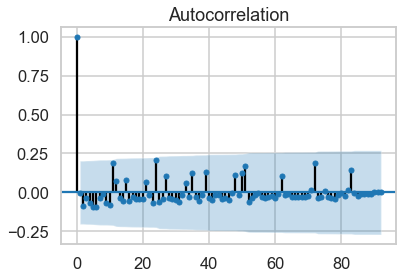

In [11]:
#画出自相关性图
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(tstmp)
plt.show()

In [10]:
#平稳性检测
from statsmodels.tsa.stattools import adfuller
print('原始序列的检验结果为：',adfuller(tstmp))
#返回值依次为：adf, pvalue p值, usedlag, nobs, critical values临界值 , icbest, regresults, resstore 
#adf 分别大于3中不同检验水平的3个临界值，单位检测统计量对应的p 值小于 0.05 ， 说明序列可以判定为 平稳序列

原始序列的检验结果为： (-9.547640166229924, 2.623101100391281e-16, 0, 92, {'1%': -3.503514579651927, '5%': -2.893507960466837, '10%': -2.583823615311909}, 1333.3387935894575)


In [24]:
#对一阶差分后的序列做白噪声检验
from statsmodels.stats.diagnostic import acorr_ljungbox
print(u'差分序列的白噪声检验结果：',acorr_ljungbox(tstmp, lags= 1)) #返回统计量和 p 值
# 差分序列的白噪声检验结果： (array([0.00386435]), array([0.95043232])) 
# p值为第二项， 远大于 0.05

差分序列的白噪声检验结果： (array([0.00386435]), array([0.95043232]))


In [46]:
#对模型进行定阶
from statsmodels.tsa.arima_model import ARIMA 
D_data = list(tstmp[:-5])
pmax = int(len(D_data) / 10)    #一般阶数不超过 length /10
qmax = int(len(D_data) / 10)
bic_matrix = []
for p in range(pmax +1):
    temp= []
    for q in range(qmax+1):
        try:
            temp.append(ARIMA(D_data, (p, 1, q)).fit().bic)
        except:
            temp.append(1e10)
        bic_matrix.append(temp)

/Users/liyunfan/miniconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/liyunfan/miniconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/liyunfan/miniconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/liyunfan/miniconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/liyunfan/miniconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available


In [47]:
bic_df = pd.DataFrame(bic_matrix).fillna(1e10)   #将其转换成Dataframe 数据结构
p,q = bic_df.stack().idxmin()   #先使用stack 展平， 然后使用 idxmin 找出最小值的位置
print(u'BIC 最小的p值 和 q 值：%s,%s' %(p,q))  #  BIC 最小的p值 和 q 值：0,3
#所以可以建立ARIMA 模型，ARIMA(0,1,1)
model = ARIMA(D_data, (p,1,q)).fit()

BIC 最小的p值 和 q 值：0,1


In [49]:
model.summary2()        #生成一份模型报告

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: ARIMA
===================================================================
Model:              ARIMA            BIC:                 1471.1397
Dependent Variable: D.y              Log-Likelihood:      -728.87  
Date:               2019-08-06 13:04 Scale:               1.0000   
No. Observations:   87               Method:              css-mle  
Df Model:           2                Sample:              1        
Df Residuals:       85                                    8        
Converged:          1.0000           S.D. of innovations: 1025.729 
No. Iterations:     5.0000           HQIC:                1466.721 
AIC:                1463.7420                                      
--------------------------------------------------------------------
               Coef.   Std.Err.     t      P>|t|    [0.025    0.975]
--------------------------------------------------------------------
const         -1.8100    4.3045   -0.4205  0.6752  -10.2467   6.6268
ma.L1.D.y     -1.0000    0.0317  -31.5474  0.0000   -1.0621  -0.9379
----------------------------------------------------------------------------
                Real           Imaginary          Modulus          Frequency
----------------------------------------------------------------------------
MA.1           1.0000             0.0000           1.0000             0.0000
===================================================================

"""

In [58]:
model.forecast(2)   #为未来5天进行预测， 返回预测结果， 标准误差， 和置信区间

(array([273.30881722, 271.49883959]),
 array([1025.7287874, 1025.7287874]),
 array([[-1737.08266398,  2283.70029843],
        [-1738.89264162,  2281.8903208 ]]))

In [61]:
import scipy.stats as stats

stats.kstest(tstmp[:-5],'expon')

KstestResult(statistic=0.9589570883839931, pvalue=1.844965655135233e-122)

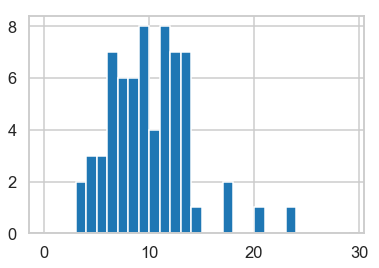

In [72]:
import matplotlib.pyplot as plt
import scipy
import scipy.stats
size=len(tstmp)
x = scipy.arange(size)
y = tstmp
# creating the histogram
h = plt.hist(y, bins=range(30))

"""dist_names = ['alpha', 'beta', 'arcsine',
              'weibull_min', 'weibull_max', 'rayleigh']

for dist_name in dist_names:
    dist = getattr(scipy.stats, dist_name)
    param = dist.fit(y)
    pdf_fitted = dist.pdf(x, *param[:-2], loc=param[-2], scale=param[-1]) * size
    plt.plot(pdf_fitted, label=dist_name)
    plt.xlim(0,29)
plt.legend(loc='upper left')"""
plt.show()

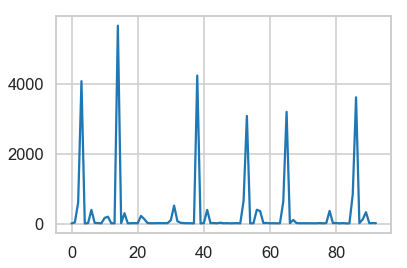

In [73]:
plt.plot(tstmp)

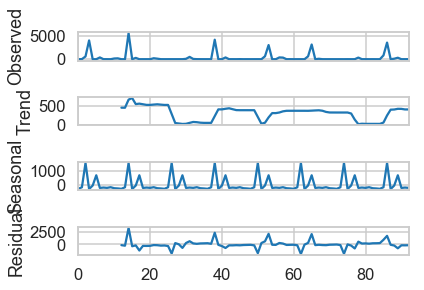

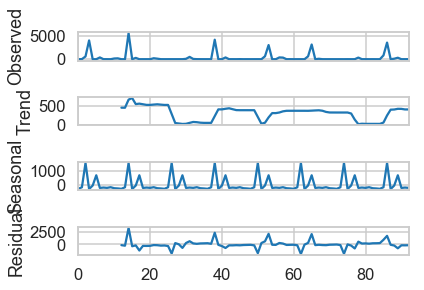

In [95]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition=seasonal_decompose(pd.Series(tstmp),freq = 12,two_sided=False)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
# trend,seasonal,residual
decomposition.plot()

[-79.61454649] 361
[-51.02481318] 13
[-81.19372325] 14
[-44.18556382] 5
[-129.81612304] 12
[-157.14191576] 4
[-193.54911771] 5
[-89.45516796] 835
[1718.12908162] 3615
[-77.84817021] 10
[210.17720347] 118
[955.75299155] 325
[22.72292503] 10
[40.27068866] 13
[5.03706481] 11


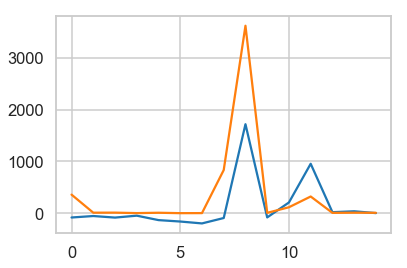

In [134]:
trend.dropna(inplace=True)
forcast=[]
tmd=-15
real=tstmp[tmd:]
plt.figure()
for x in range(tmd,0):
    dd=list(tstmp[:x])
    pred_model= ARIMA(dd, (0,1,1)).fit()
    forcast.append(pred_model.forecast(1)[0]+list(seasonal)[x])
    print(forcast[-1],tstmp[x])
plt.plot(range(0-tmd),forcast)
plt.plot(range(0-tmd),real)
plt.show()

In [130]:
seasonal[-5:]

88    -63.131614
89    692.457672
90   -239.137566
91   -211.982804
92   -234.661376
dtype: float64

In [ ]:
from sklearn.cluster import KMeans
# data = np.random.rand(100, 3) #生成一个随机数据，样本大小为100, 特征数为3

#假如我要构造一个聚类数为3的聚类器
estimator = KMeans(n_clusters=3)#构造聚类器
estimator.fit(tstmp)#聚类
label_pred = estimator.labels_ #获取聚类标签
centroids = estimator.cluster_centers_ #获取聚类中心
inertia = estimator.inertia_ # 获取聚类准则的总和
estimator.describe()

In [ ]:
nn=[]
for i in range(0,1000,1):
    a=req_seq.Timestamp[req_seq.fid==i]
    nn.append(max(a)-min(a))
print(nn)

In [68]:
max(nn),min(nn)

(573996914, 37141)

In [65]:
x = req_seq.Timestamp[req_seq.fid==0]
X = np.array([list(x),np.zeros(len(x))], dtype=np.int).T

In [66]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# x = req_seq.fid[req_seq.fid==0][req_seq.Timestamp<manual_end] 
# x = [[i.index,i.value] for i in x]
# X = np.array([x.index,list(x)], dtype=np.int)
bandwidth = estimate_bandwidth(X, quantile=0.1)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

for k in range(n_clusters_):
    my_members = labels == k
    print("cluster {0}: {1}".format(k, X[my_members, 0]))


cluster 0: [395233785 408493026 408493933 408514011 408539043 431305349 431305349
 431306599 433478143 434924802 434939615 439375575 439395637 439460871
 442423904 442438967 442469014 444307804 444322522 444332601 447543814]
cluster 1: [163292749 163296952 163312030 163322061 163377202 174282249 179796120
 179816198 179889354 182875319 184727666 184747776 184757744 184777760]
cluster 2: [484003659 484005237 484013690 484028800 484083972 518273809 518273809
 518275028 519878142 521888669 521901419]
cluster 3: [307599819 307610116 307635180 307655181 312416669 312428763 312448872]
cluster 4: [334460062 334480203 344954969 344954969 347077121 348528930 348530133
 348550176]
cluster 5: [     11      11    8557 1476532 5537991 5540975 5555975]
cluster 6: [221623585 221643678 221645303 221653725 221698787 221713787]
cluster 7: [ 87878098  92591161  92591161  92592427 100940811 100955170]
cluster 8: [573881705 573883127 573891768 573906861 573996925]
cluster 9: [259107601 259107601 262679203 

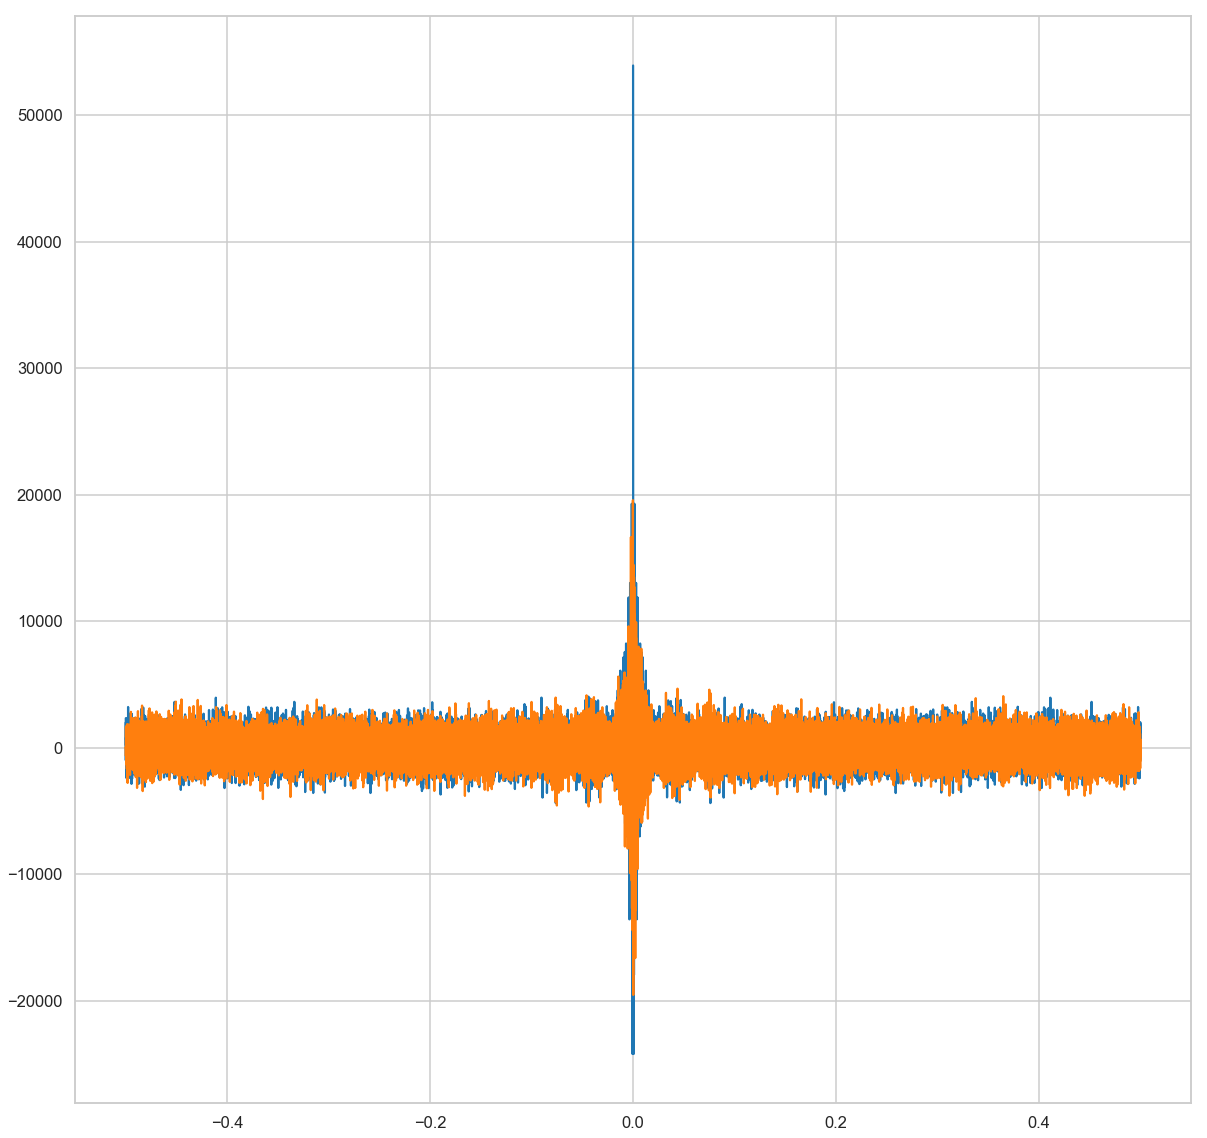

In [30]:
plt.figure(figsize=(20, 20))
res=np.fft.fft(ts)
freq = np.fft.fftfreq(ts.shape[-1])
plt.plot(freq, res.real, freq, res.imag)
plt.show()

In [33]:
pd.DataFrame(res,freq)

,0
0.000000,(53936+0j)
0.000032,(-2957.6748863866596-776.3473470685657j)
0.000064,(4631.034527436377+143.32157264646372j)
0.000096,(1281.4417629155305-5721.200824784065j)
0.000128,(-7446.61421080024+2287.0104184640786j)
0.000159,(11680.353246412893+5175.212066841917j)
0.000191,(11429.641003934095-19562.043138318877j)
0.000223,(12418.001537054151+3863.485683398965j)
0.000255,(-5607.730249962298-5052.407776436464j)
0.000287,(-8677.721348049421-3159.376641367161j)


/Users/liyunfan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


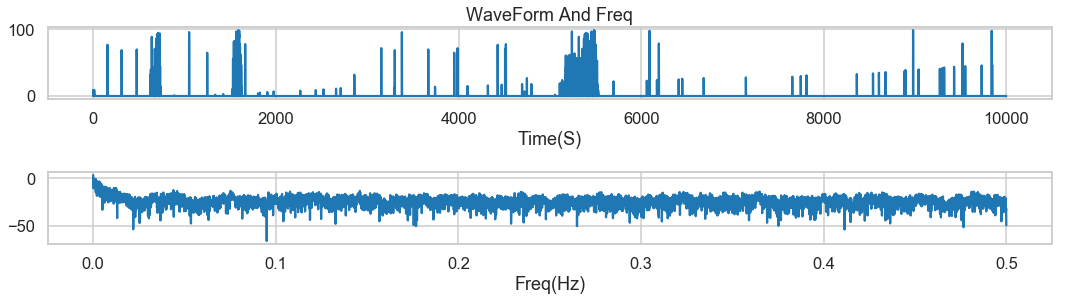

In [57]:
import numpy as np#导入一个数据处理模块
import pylab as pl#导入一个绘图模块，matplotlib下的模块

sampling_rate = 1#采样频率
fft_size = 10000 #FFT处理的取样长度
t = ts.index
x = list(ts)
# N点FFT进行精确频谱分析的要求是N个取样点包含整数个取样对象的波形。因此N点FFT能够完美计算频谱对取样对象的要求是n*Fs/N（n*采样频率/FFT长度），
# 因此对8KHZ和512点而言，完美采样对象的周期最小要求是8000/512=15.625HZ,所以156.25的n为10,234.375的n为15。
xs = x[:fft_size]# 从波形数据中取样fft_size个点进行运算
xf = np.fft.rfft(xs)/fft_size# 利用np.fft.rfft()进行FFT计算，rfft()是为了更方便对实数信号进行变换，由公式可知/fft_size为了正确显示波形能量
# rfft函数的返回值是N/2+1个复数，分别表示从0(Hz)到sampling_rate/2(Hz)的分。
#于是可以通过下面的np.linspace计算出返回值中每个下标对应的真正的频率：
freqs = np.linspace(0, sampling_rate/2, fft_size/2+1)
# np.linspace(start, stop, num=50, endpoint=True, retstep=False, dtype=None)
#在指定的间隔内返回均匀间隔的数字
xfp = 20*np.log10(np.clip(np.abs(xf), 1e-20, 1e100))
#最后我们计算每个频率分量的幅值，并通过 20*np.log10()将其转换为以db单位的值。为了防止0幅值的成分造成log10无法计算，我们调用np.clip对xf的幅值进行上下限处理

#绘图显示结果
pl.figure(figsize=(18,4))
pl.subplot(211)
pl.plot(t[:fft_size], xs)
pl.xlabel(u"Time(S)")
pl.title(u"WaveForm And Freq")
pl.subplot(212)
pl.plot(freqs, xfp)
pl.xlabel(u"Freq(Hz)")
pl.subplots_adjust(hspace=1)
pl.show()

In [52]:
a = pd.DataFrame(req_seq.fid[req_seq.fid==1])
# pd.Series.to_frame(series)
a['id'] = list(a.index)
a

,fid,id
7,1,7
9,1,9
14,1,14
638,1,638
889,1,889
4719,1,4719
4727,1,4727
5132,1,5132
5137,1,5137
5150,1,5150


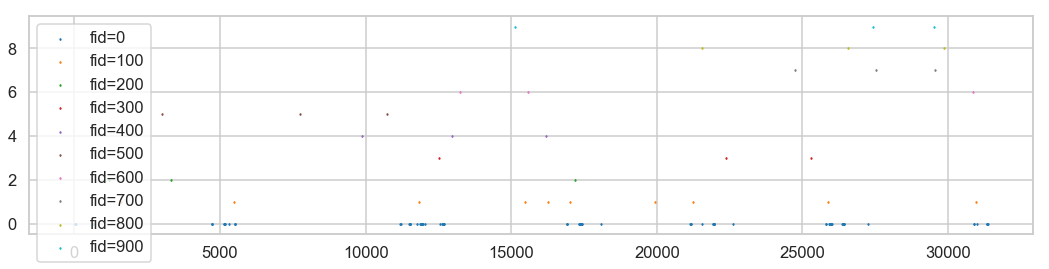

In [70]:
pl.figure(figsize=(18,4))
for i in range(0,1000,100):
    a = pd.DataFrame(req_seq.fid[req_seq.fid==i])
    plt.scatter(a.index,np.zeros(len(a))+0.01*i,s=1,marker='d',label='fid='+str(i))
plt.legend()
plt.show()

In [67]:
np.zeros(10)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
import numpy as np
import pywt
from matplotlib.font_manager import FontProperties

chinese_font = FontProperties(fname='/System/Library/Fonts/STHeiti Light.ttc')

In [ ]:
sampling_rate = 1024
t = np.arange(0, 1.0, 1.0 / sampling_rate)
f1 = 100
f2 = 200
f3 = 300
data = np.piecewise(t, [t < 1, t < 0.8, t < 0.3],
                    [lambda t: np.sin(2 * np.pi * f1 * t), lambda t: np.sin(2 * np.pi * f2 * t),
                     lambda t: np.sin(2 * np.pi * f3 * t)])
wavename = 'cgau8'
totalscal = 256

In [64]:
data

array([ 0.        ,  0.96377607, -0.51410274, ..., -0.96377607,
       -0.94154407, -0.57580819])

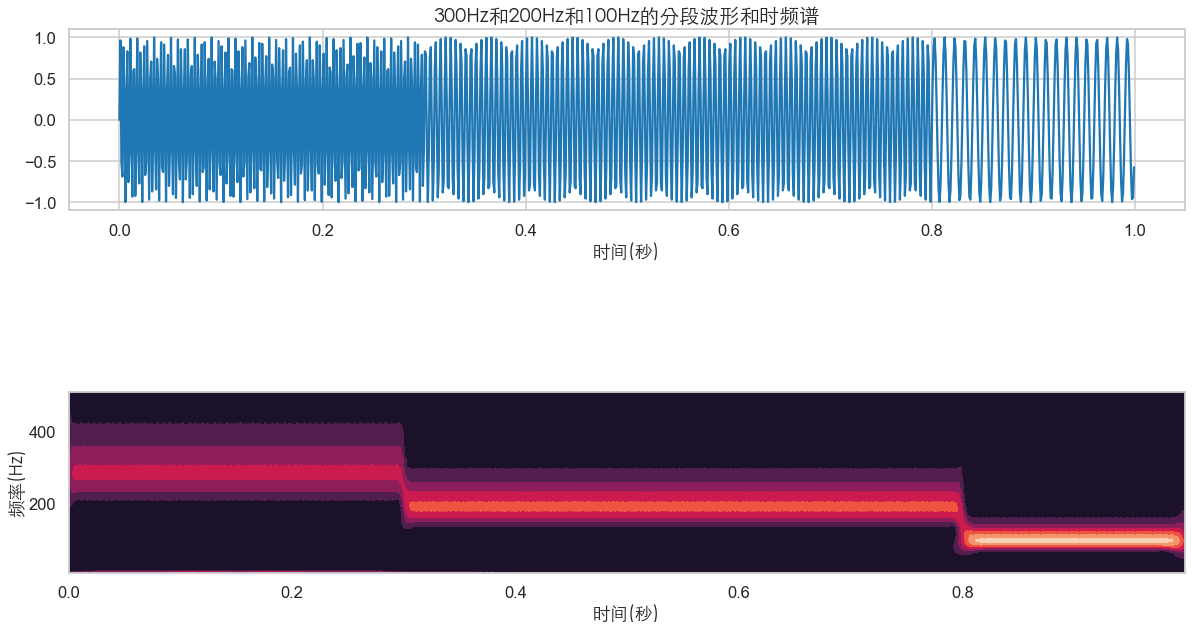

In [63]:
fc = pywt.central_frequency(wavename)
cparam = 2 * fc * totalscal
scales = cparam / np.arange(totalscal, 1, -1)
[cwtmatr, frequencies] = pywt.cwt(data, scales, wavename, 1.0 / sampling_rate)
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(t, data)
plt.xlabel(u"时间(秒)", fontproperties=chinese_font)
plt.title(u"300Hz和200Hz和100Hz的分段波形和时频谱", fontproperties=chinese_font, fontsize=20)
plt.subplot(212)
plt.contourf(t, frequencies, abs(cwtmatr))
plt.ylabel(u"频率(Hz)", fontproperties=chinese_font)
plt.xlabel(u"时间(秒)", fontproperties=chinese_font)
plt.subplots_adjust(hspace=1)
plt.show()